# M-PHATE Demonstration
## Classification (tensorflow)

In this notebook, we demonstrate the use of M-PHATE to visualize the evolution of a simple 3-layer classifier over the course of training.

### 1. Setup

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import scprep

import m_phate
import m_phate.train
import m_phate.data

Using TensorFlow backend.


Let's set the session so we can limit what percentage of the GPU is used, for courtesy's sake.

In [2]:
sess = tf.InteractiveSession(config=m_phate.train.build_config(limit_gpu_fraction=0.2))

Now we load MNIST in preprocessed form.

In [3]:
x_train, x_test, y_train, y_test = m_phate.data.load_mnist()

### 2. Build the neural network

In [4]:
# input layer
inputs = tf.keras.layers.Input(
    shape=(x_train.shape[1],), dtype='float32', name='inputs')

# three dense hidden layers
h1 = tf.keras.layers.Dense(64, name='h1')(inputs)
h2 = tf.keras.layers.Dense(64, name='h2')(tf.nn.leaky_relu(h1))
h3 = tf.keras.layers.Dense(64, name='h3')(tf.nn.leaky_relu(h2))

# output layer
logits = tf.keras.layers.Dense(10, name='outputs')((tf.nn.leaky_relu(h3)))
# true labels
labels = tf.keras.layers.Input(
    shape=(y_train.shape[1],), dtype='float32', name='labels')

# cross entropy loss
loss_op = tf.losses.softmax_cross_entropy(labels, logits)
# categorical accuracy
_, accuracy_op = tf.metrics.accuracy(tf.argmax(labels, axis=1), tf.argmax(logits, axis=1))

# build the optimizer
optimizer = tf.train.AdamOptimizer(1e-5)
train_op = optimizer.minimize(loss_op)

# initialize variables
_ = sess.run([tf.global_variables_initializer(), tf.local_variables_initializer()])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


### 3. Set up the neural network trace

Here we randomly select ten examples of every digit from the test set - the hidden activations of these images will form our data tensor to be visualized.

In [5]:
np.random.seed(42)
# select the digit indices in the test set
trace_idx = []
for i in range(10):
    trace_idx.append(np.random.choice(np.argwhere(
        y_test[:, i] == 1).flatten(), 10, replace=False))

trace_idx = np.concatenate(trace_idx)
# extract the selected images
trace_data = x_test[trace_idx]

### 4. Train the network

In [6]:
# create a dictionary in which to store trace, loss, accuracy etc
history = {'trace':[], 'loss':[], 'val_loss':[], 'accuracy':[], 'val_accuracy':[]}

# train!
batch_size = 128
epochs = 200
verbose = False
for epoch in range(epochs):
    # randomize batch order
    batch_idx = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
    
    # run minibatch training
    epoch_loss = []
    epoch_acc = []
    for batch in range(x_train.shape[0] // batch_size):
        # get one batch worth of data
        x_batch = x_train[batch_idx[batch * batch_size:(batch + 1) * batch_size]]
        y_batch = y_train[batch_idx[batch * batch_size:(batch + 1) * batch_size]]
        # gradient step
        _, batch_loss, batch_acc = sess.run([train_op, loss_op, accuracy_op], 
                                            feed_dict={inputs : x_batch, labels : y_batch})
        # store loss and accuracy
        epoch_loss.append(batch_loss)
        epoch_acc.append(batch_acc)

    # mean loss and accuracy for the epoch
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    
    # validation loss and accuracy
    epoch_val_loss, epoch_val_acc = sess.run([loss_op, accuracy_op], 
                                              feed_dict={inputs : x_test, labels : y_test})
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_acc)
    
    if verbose:
        print("Epoch {}/{}:\tloss={:.3f}\tval_loss={:.3f}\tacc={:.3f}\tval_acc={:.3f}".format(
            epoch, epochs, epoch_loss, epoch_val_loss, epoch_acc, epoch_val_acc))
    
    # store the activations of the trace data
    epoch_trace = sess.run([h1, h2, h3],
                          feed_dict={inputs : trace_data})
    epoch_trace = np.concatenate([layer_trace.T for layer_trace in epoch_trace])
    history['trace'].append(epoch_trace)

### 5. Retrieve the output

There are a lot of metadata features we might be interested in visualizing, so we show you all of them here.

The most important element here is the first: the `n_epochs x n_neurons x n_examples` tensor. We often refer to the _flattened tensor_ as this is what will be returned by M-PHATE: this is the `n_epochs*n_neurons x n_dim` matrix to be visualized.

In [7]:
# the actual data tensor
trace_data = np.array(history['trace'])
n_epochs = trace_data.shape[0]
n_neurons = trace_data.shape[1]

# the train loss for each element of the flattened trace
loss = np.repeat(history['loss'], n_neurons)
# the validation loss for each element of the flattened trace
val_loss = np.repeat(history['val_loss'], n_neurons)
# the train accuracy for each element of the flattened trace
accuracy = np.repeat(history['accuracy'], n_neurons)
# the validation accuracy for each element of the flattened trace
val_accuracy = np.repeat(history['val_accuracy'], n_neurons)

# the unique neuron id for each element of the flattened trace
neuron_ids = np.tile(np.arange(n_neurons), n_epochs)
# the hidden layer that each element of the flattened trace belongs to
layer_ids = np.tile(np.concatenate([np.repeat(i, int(layer.shape[1]))
                                    for i, layer in enumerate([h1, h2, h3])]),
                    n_epochs)
# the current epoch for each element of the flattened trace
epoch = np.repeat(np.arange(n_epochs), n_neurons)

# the label of each digit we selected: this should be the same as `np.repeat(np.arange(10), 10)`
digit_ids = y_test.argmax(1)[trace_idx]
# the average activity over digit labels for each element of the flattened trace
digit_activity = np.array([np.sum(np.abs(trace_data[:, :, digit_ids == digit]), axis=2)
                           for digit in np.unique(digit_ids)])
# the digit label with the highest average activity for each element of the flattened trace
most_active_digit = np.argmax(digit_activity, axis=0).flatten()

### 6. Visualize the data tensor

Calculating PHATE...
  Calculating M-PHATE...
    Calculating multislice kernel...
    Calculated multislice kernel in 9.61 seconds.
    Calculating graph and diffusion operator...
      Calculating landmark operator...
        Calculating SVD...
        Calculated SVD in 10.37 seconds.
        Calculating KMeans...
        Calculated KMeans in 83.16 seconds.
      Calculated landmark operator in 99.05 seconds.
    Calculated graph and diffusion operator in 99.75 seconds.
    Running PHATE on precomputed affinity matrix with 200 cells.
  Calculated M-PHATE in 109.38 seconds.
  Calculating optimal t...
    Automatically selected t = 41
  Calculated optimal t in 44.08 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 23.41 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 280.09 seconds.
Calculated PHATE in 456.99 seconds.


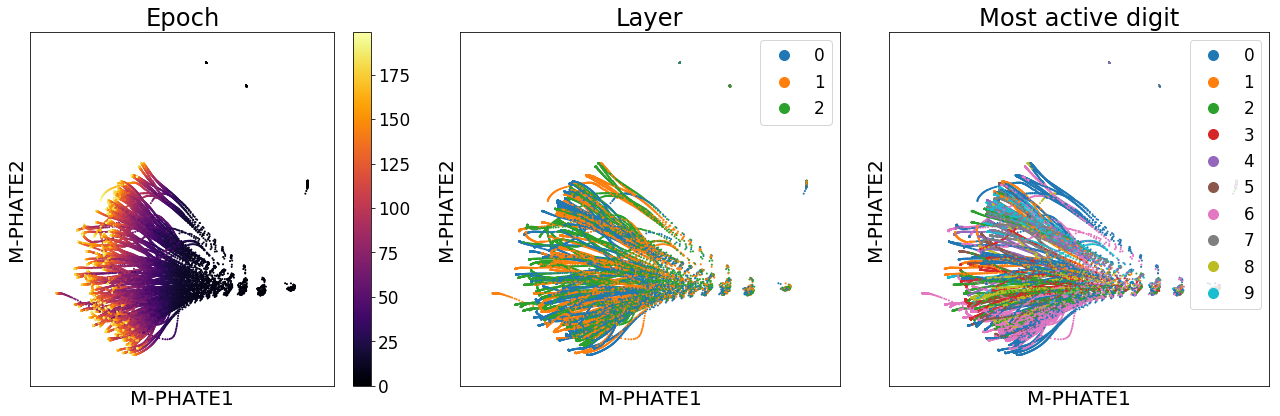

In [8]:
# calculate M-PHATE
m_phate_op = m_phate.M_PHATE()
m_phate_data = m_phate_op.fit_transform(trace_data)

# plot the results
plt.rc('font', size=14)
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3, figsize=(18, 6), sharex='all', sharey='all')
scprep.plot.scatter2d(m_phate_data, c=epoch, ax=ax1, ticks=False,
                      title='Epoch', label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=layer_ids, ax=ax2, title='Layer',
                      ticks=False, label_prefix="M-PHATE")
scprep.plot.scatter2d(m_phate_data, c=most_active_digit, ax=ax3,
                      title='Most active digit',
                      ticks=False, label_prefix="M-PHATE")
plt.tight_layout()

In [9]:
# do it in 3D!
m_phate_op.set_params(n_components=3)
m_phate_data = m_phate_op.transform()

# plot the results
scprep.plot.rotate_scatter3d(m_phate_data, c=most_active_digit,
                             title='Most active digit',
                             ticks=False, label_prefix="M-PHATE")

Calculating metric MDS...
Calculated metric MDS in 220.08 seconds.
